In [1]:
import numpy as np
import pandas as pd
from SERGIO.sergio import sergio

# Simulate Clean Data _ Steady-State Simulation

In [49]:
path = 'data_sets/De-noised_100G_9T_300cPerT_4_DS1/'
input_file_taregts=  path + 'Interaction_cID_4.txt'
input_file_regs= path + 'Regs_cID_4.txt'

def input_parameters_from_datafiles(input_file_regs,input_file_taregts):
    tb = pd.read_csv(input_file_regs,sep = ',',header = None,index_col=0)
    n_MR, n_celltypes = tb.shape#n_MR number of Master regulator
    
    with open(input_file_taregts) as f:
        reader = csv.reader(f, delimiter="\t")
        for count,line in enumerate(reader):
            pass
    n_reg_genes = count+1#number of regulated genes, i.e. genes that are not master regulator
    return n_MR,n_reg_genes,n_celltypes
n_MR,n_reg_genes,n_celltypes = input_parameters_from_datafiles(input_file_regs,input_file_taregts)
n_MR,n_reg_genes,n_celltypes


(7, 93, 9)

In [48]:
sim = sergio(number_genes=n_MR+n_reg_genes, number_bins = n_celltypes, number_sc = 300, noise_params = 1, decays=0.8, sampling_state=15, noise_type='dpd')
sim.build_graph(input_file_taregts = input_file_taregts, input_file_regs= input_file_regs, shared_coop_state=2)
sim.simulate()
expr = sim.getExpressions()
expr_clean = np.concatenate(expr, axis = 1)

Start simulating new level
There are 4 genes to simulate in this layer
Done with current level
Start simulating new level
There are 6 genes to simulate in this layer
Done with current level
Start simulating new level
There are 90 genes to simulate in this layer
Done with current level


In [40]:

n_MR

7

# Add Technical Noise _ Steady-State Simulations

In [7]:
"""
Add outlier genes
"""
expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 0.8, scale = 1)

"""
Add Library Size Effect
"""
libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.6, scale = 0.4)

"""
Add Dropouts
"""
binary_ind = sim.dropout_indicator(expr_O_L, shape = 6.5, percentile = 82)
expr_O_L_D = np.multiply(binary_ind, expr_O_L)

"""
Convert to UMI count
"""
count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)

"""
Make a 2d gene expression matrix
"""
count_matrix = np.concatenate(count_matrix, axis = 1)

# Simulate Clean Data _ differentiation Simulation

In [ ]:
df = pd.read_csv('data_sets/De-noised_100G_6T_300cPerT_dynamics_7_DS6/bMat_cID7.tab', sep='\t', header=None, index_col=None)
bMat = df.values

sim = sergio(number_genes=100, number_bins = 6, number_sc = 300, noise_params = 0.2, decays=0.8, sampling_state = 1, noise_params_splice = 0.07, noise_type='dpd', dynamics=True, bifurcation_matrix= bMat)
sim.build_graph(input_file_taregts ='data_sets/De-noised_100G_6T_300cPerT_dynamics_7_DS6/Interaction_cID_7.txt', input_file_regs='data_sets/De-noised_100G_6T_300cPerT_dynamics_7_DS6/Regs_cID_7.txt', shared_coop_state=2)
sim.simulate_dynamics()
exprU, exprS = sim.getExpressions_dynamics()
exprU_clean = np.concatenate(exprU, axis = 1)
exprS_clean = np.concatenate(exprS, axis = 1)

# Add Technical Noise _ differentiation Simulations

In [ ]:
"""
Add outlier genes
"""
exprU_O, exprS_O = sim.outlier_effect_dynamics(exprU, exprS, outlier_prob = 0.01, mean = 0.8, scale = 1)

"""
Add Library Size Effect
"""
libFactor, exprU_O_L, exprS_O_L = sim.lib_size_effect_dynamics(exprU_O, exprS_O, mean = 4.6, scale = 0.4)

"""
Add Dropouts
"""
binary_indU, binary_indS = sim.dropout_indicator_dynamics(exprU_O_L, exprS_O_L, shape = 6.5, percentile = 82)
exprU_O_L_D = np.multiply(binary_indU, exprU_O_L)
exprS_O_L_D = np.multiply(binary_indS, exprS_O_L)

"""
Convert to UMI count
"""
count_matrix_U, count_matrix_S = sim.convert_to_UMIcounts_dynamics(exprU_O_L_D, exprS_O_L_D)

"""
Make 2d spliced and unspliced expression matrices
"""
count_matrix_U = np.concatenate(count_matrix_U, axis = 1)
count_matrix_S = np.concatenate(count_matrix_S, axis = 1)

### Create a network from here

In [4]:
import scanpy as sc
import pandas as pd
import csv
import networkx as nx
from SERGIO.utils import convert_interaction_net_to_networkx

In [5]:

adata = sc.AnnData(expr_clean.T)
adata.raw = sc.AnnData(count_matrix.T)

/tmp/ipykernel_46514/1367336537.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(expr_clean.T)
/tmp/ipykernel_46514/1367336537.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.raw = sc.AnnData(count_matrix.T)


In [17]:

G = convert_interaction_net_to_networkx(input_file_taregts)

In [18]:
#to save data
import pickle

In [ ]:
dic = {'adata':adata,'G':G}
# Store data (serialize)
with open('', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [9]:
import matplotlib.pyplot as plt

(array([ 7.,  1.,  0., 62.,  0.,  9.,  6.,  0.,  8.,  7.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

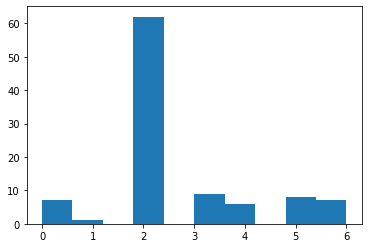

In [12]:
plt.hist(dict(G.in_degree()).values())

(array([16., 20., 22., 21.,  0.,  0., 42., 46., 40., 51.]),
 array([-4.94710895, -3.95617141, -2.96523387, -1.97429632, -0.98335878,
         0.00757876,  0.9985163 ,  1.98945385,  2.98039139,  3.97132893,
         4.96226648]),
 <BarContainer object of 10 artists>)

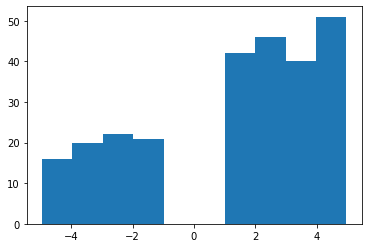

In [19]:
plt.hist([el[2]['weight'] for el in G.edges(data = True)])

In [29]:
data = []
with open(input_file_taregts) as f:
    reader = csv.reader(f, delimiter="\t")
    for line in reader:
        data+=[line[0].split(',')[0]]
len(np.unique(np.rint(np.array(data,dtype = float))))

93

In [26]:
path = input_file_taregts.rsplit('/',1)[0]

'data_sets/De-noised_100G_9T_300cPerT_4_DS1'

(array([ 1.,  5., 14., 25., 30., 11., 11.,  2.,  0.,  1.]),
 array([0.90949607, 0.93237131, 0.95524656, 0.9781218 , 1.00099704,
        1.02387228, 1.04674752, 1.06962276, 1.092498  , 1.11537324,
        1.13824848]),
 <BarContainer object of 10 artists>)

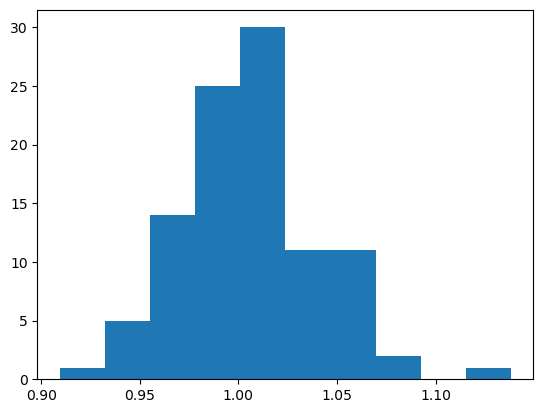

In [10]:

plt.hist(np.mean(expr_clean,axis = 1)/adata.X.mean(axis = 0))

In [14]:
list(zip(1-np.exp(-count_matrix.mean(axis = 1)),1-np.exp(-adata.X.mean(axis = 0))))

[(0.3156064916798721, 0.9947406),
 (0.49214309571146, 0.99849963),
 (0.08748938029063857, 0.9503876),
 (0.04368379922274945, 0.8585861),
 (0.11081009018629906, 0.9452028),
 (0.15191785415175563, 0.9629531),
 (0.27344743471381017, 0.98910713),
 (0.18172397101645077, 0.97118074),
 (0.11130394738538263, 0.96153694),
 (0.10247213442846259, 0.94029903),
 (0.09737170562363928, 0.9377603),
 (0.22534176449210597, 0.9868003),
 (0.25148696965742445, 0.9880806),
 (0.1980160362716098, 0.9800015),
 (0.49473218657594986, 0.99857444),
 (0.07985335253399883, 0.93263036),
 (0.30333070114965544, 0.99273777),
 (0.008408890272253222, 0.58632046),
 (0.19363777134069526, 0.9777209),
 (0.20307921770986037, 0.98538494),
 (0.22318694464034772, 0.9828382),
 (0.34105230053466007, 0.9959777),
 (0.10734539688878897, 0.9616289),
 (0.08311917570991689, 0.939947),
 (0.29593802138154435, 0.99213827),
 (0.10107489350971821, 0.9439931),
 (0.2541436235817759, 0.9876112),
 (0.0939553274158128, 0.9407713),
 (0.160169804299